In [1]:
#modify codes from https://acadgild.com/blog/random-forest-algorithm-regression
#
import numpy as np
import pandas as pd

#import pyreadr #read .Rda file
#import pyreadstat #read stata

#one hot encoding
from sklearn.preprocessing import LabelBinarizer

#plot
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *

#evaluate model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

#explain shapley values
import shap

#random forest regression
from sklearn.ensemble import RandomForestRegressor

#PCA
from sklearn.decomposition import PCA

#TSNE
from sklearn import (manifold,datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)
from sklearn.manifold import TSNE

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
#data from Standfirm trial stata data
#dtafile = './goal1.dta'
#df, meta = pyreadstat.read_dta(dtafile)
#df.head()

#data from .Rda
#datafile='./newdat261219.train.Rda'
#result = pyreadr.read_r(datafile)
#result #OrderDict class
#print(result.keys()) #odict_keys(['newdat.train'])
#newdat.train = result['newdat.train'] # extract the pandas data frame for object df1


In [3]:
#data from standfirm
#Framingham risk score 10-year risk in %: 
#Points total: 0 point: <1%. 1-4 points: 1%. 5-6 points: 2%. 7 points: 3%. 8 points: 4%. 9 points: 5%. 10 points: 6%. 11 points: 8%. 12 points: 10%. 13 points: 12%. 14 points: 16%. 15 points: 20%. 16 points: 25%. 17 points or more: Over 30%.[17]

dftrain=pd.read_csv("newdat261219.train.csv",index_col=0) #remove unnamed column 0
dftest=pd.read_csv("newdat261219.test.csv",index_col=0)
#dftrain.head()
#dftrain.tail()

#Male is 1 and Female is 2
dftrain["Male1"].loc[(dftrain["Male1"] == 2) ] = 0
dftest["Male1"].loc[(dftest["Male1"] == 2) ] = 0

#change column names
dftrain.rename(columns={'base_age':'age',
                        'Male1':'Male',
                        'base_HbA1c':'HbA1c',
                        'HighEd':'HigherEducation',
                        'SocClass':'SocialClass',
                        'base_chol':'Cholesterol',
                        'base_Glu':'serumglucose',
                        'base_meanDBP':'meanDiastolicBloodPressure',
                        'base_CreatExcr':'CreatinineExceretion',
                        'base_lhs':'LondonHandicapScore',
                        'SodbyPot':'SodiumPotassiumratio',
                        'base_salt_calc':'Saltintake',
                        'base_Ev_smoke1':'EverSmoker',
                        'base_SodExcr':'UrinarySodiumExcretion',
                        'base_PotExcr':'UrinaryPotassiumExcretion',
                        'base_Veg_serves31':'Vegetable'})
                   

 #list(dftrain)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,base_dep,base_anx,Marital_Status,LivStat,FluEng,HigherEducation,SocialClass,Male,age,base_AlcUse,...,serumglucose,UrinarySodiumExcretion,UrinaryPotassiumExcretion,CreatinineExceretion,base_proteinuria,Vegetable,base_Fruit_serves32,base_frs1,_12m_frs1,SodiumPotassiumratio
541,1,1,4,1,1,3,4,1,74.047913,3,...,5.2,184,75,12.9,0,3.0,3.0,27.902880,23.191458,2.453333
201,0,0,2,1,1,6,1,1,71.767281,3,...,5.8,150,127,14.3,0,3.0,1.0,22.923349,18.686975,1.181102
142,3,6,2,1,1,4,2,1,75.044487,3,...,4.1,158,96,17.8,0,2.0,3.0,38.322948,57.030106,1.645833
157,10,7,2,1,1,5,4,1,66.669403,3,...,3.6,197,86,12.8,1,2.0,1.0,64.901901,75.938080,2.290698
87,1,1,2,1,1,4,3,1,80.722794,3,...,6.1,116,48,6.2,0,1.0,1.0,31.392309,35.849663,2.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,5,3,2,1,1,7,2,1,74.447639,1,...,5.0,164,75,12.9,0,1.5,0.2,35.652866,38.182926,2.186667
189,3,8,2,1,1,5,4,1,63.589321,3,...,4.7,70,35,7.3,1,1.5,0.0,37.399849,27.003273,2.000000
367,7,7,2,1,1,6,2,1,53.240246,3,...,6.7,146,78,13.8,0,0.0,1.0,13.648759,13.147925,1.871795
238,9,12,4,1,1,3,6,0,47.496235,3,...,5.1,169,86,11.0,0,5.0,2.0,4.069652,8.282673,1.965116


In [4]:
dftest.rename(columns={'base_age':'age',
                        'Male1':'Male',
                        'base_HbA1c':'HbA1c',
                        'HighEd':'HigherEducation',
                        'SocClass':'SocialClass',
                        'base_chol':'Cholesterol',
                        'base_Glu':'serumglucose',
                        'base_meanDBP':'meanDiastolicBloodPressure',
                        'base_CreatExcr':'CreatinineExceretion',
                        'base_lhs':'LondonHandicapScore',
                        'SodbyPot':'SodiumPotassiumratio',
                        'base_salt_calc':'Saltintake',
                        'base_Ev_smoke1':'EverSmoker',
                        'base_SodExcr':'UrinarySodiumExcretion',
                        'base_PotExcr':'UrinaryPotassiumExcretion',
                        'base_Veg_serves31':'Vegetable'})                  
#list(dftest)

,base_dep,base_anx,Marital_Status,LivStat,FluEng,HigherEducation,SocialClass,Male,age,base_AlcUse,...,serumglucose,UrinarySodiumExcretion,UrinaryPotassiumExcretion,CreatinineExceretion,base_proteinuria,Vegetable,base_Fruit_serves32,base_frs1,_12m_frs1,SodiumPotassiumratio
82,4,5,2,2,2,6,1,1,73.333336,1,...,5.7,136.0,42,10.5,0,1.5,1.0,40.630459,38.553707,3.238095
404,1,2,2,1,1,3,4,1,81.067764,3,...,6.8,170.0,82,11.2,0,4.0,2.0,32.067249,29.589983,2.073171
561,0,5,2,1,1,3,5,1,66.343597,3,...,5.0,121.0,67,12.6,0,1.0,2.0,33.259827,36.420551,1.805970
33,2,2,3,1,1,3,3,0,66.663925,3,...,5.2,154.0,54,7.4,0,2.0,0.4,9.035308,6.618856,2.851852
421,6,2,5,1,1,4,3,0,72.380562,3,...,4.2,101.0,34,3.5,0,2.0,2.0,19.565790,14.564616,2.970588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,5,3,2,1,1,6,1,0,60.958248,3,...,4.5,73.0,73,6.2,0,4.0,1.0,4.678344,6.720607,1.000000
400,9,17,2,1,1,3,6,1,53.804245,2,...,5.0,413.0,113,19.9,1,3.0,3.0,7.044027,6.363365,3.654867
117,7,3,5,1,1,3,6,0,84.350449,3,...,7.4,91.0,44,4.6,0,1.0,2.0,19.137770,17.433050,2.068182
79,8,14,2,1,1,6,2,0,74.277893,3,...,5.3,149.0,70,7.6,0,3.0,1.0,21.414522,48.892147,2.128571


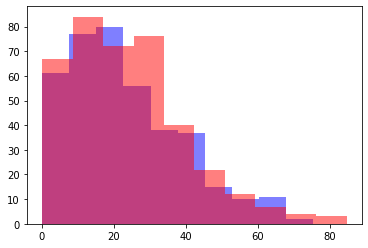

In [5]:
#hisogram plot of framingham risk score
num_bins = 10
n, bins, patches = plt.hist(dftrain['base_frs1'], num_bins, facecolor='blue', alpha=0.5)
plt.show

num_bins = 10
n, bins, patches = plt.hist(dftrain['_12m_frs1'], num_bins, facecolor='red', alpha=0.5)
plt.show

#iloc integer location
#X = df.iloc[:,:-1] #row by column, select all columns except remove last column
#y = df.iloc[:,-2] #or y = df['SodbyPot'] second last column

#create new columns
dftrain['changefrs12m'] = (dftrain['base_frs1']-dftrain['_12m_frs1'])/dftrain['_12m_frs1']
dftrain['rawchangefrs12m'] = (dftrain['base_frs1']-dftrain['_12m_frs1'])

dftest['changefrs12m'] = (dftest['base_frs1']-dftest['_12m_frs1'])/dftest['_12m_frs1']
dftest['rawchangefrs12m'] = (dftest['base_frs1']-dftest['_12m_frs1'])
##################
#test changefrs12m
#poor results
##################

#drop train
#x_training_set = dftrain.drop(['base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
#y_training_set = dftrain['changefrs12m']
#drop test
#x_test_set = dftest.drop(['base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
#y_test_set = dftest['changefrs12m']


###########################
#test prediction of frs 12m
###########################
#drop train
x_training_set = dftrain.drop(['rawchangefrs12m','base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_training_set = dftrain['_12m_frs1']

x_training2_set = dftrain.drop(['rawchangefrs12m','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_training2_set=dftrain['changefrs12m'] #keep baseline frs

x_training3_set = dftrain.drop(['rawchangefrs12m','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_training3_set=dftrain['rawchangefrs12m'] #keep baseline frs

#drop test
x_test_set = dftest.drop(['rawchangefrs12m','base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_test_set = dftest['_12m_frs1']

x_test2_set = dftest.drop(['rawchangefrs12m','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_test2_set= dftest['changefrs12m']

x_test3_set = dftest.drop(['rawchangefrs12m','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
y_test3_set= dftest['rawchangefrs12m']

In [6]:
list(dftrain)

['base_dep',
 'base_anx',
 'Marital_Status',
 'LivStat',
 'FluEng',
 'HighEd',
 'SocClass',
 'Male1',
 'base_age',
 'base_AlcUse',
 'DiabHist38a',
 'StrokeHist',
 'IHDHist38d',
 'AFHist38f',
 'RheumHist38g',
 'PaceHist38h',
 'CarotStenHist',
 'base_Ev_smoke1',
 'base_salt_calc',
 'base_meanDBP',
 'base_cons2fruit',
 'base_lhs',
 'base_Weight',
 'base_SBP2',
 'base_Chol',
 'base_HbA1c',
 'base_Glu',
 'base_SodExcr',
 'base_PotExcr',
 'base_CreatExcr',
 'base_proteinuria',
 'base_Veg_serves31',
 'base_Fruit_serves32',
 'base_frs1',
 '_12m_frs1',
 'SodbyPot',
 'changefrs12m',
 'rawchangefrs12m']

In [7]:
#https://www.datacamp.com/community/tutorials/categorical-data
#lb = LabelBinarizer()
#lb_results = lb.fit_transform(dftrain['Male1'])
#lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
#lb_results

#dftrain['Malebin'] = lb_make.fit_transform(dftrain['Male1'])
#dftest['Male1bin'] = lb_make.fit_transform(dftest['Male1'])


In [8]:
#Identify the predictor variables and encode any string variables to equivalent integer codes 
#dftrain['Marital_Status'],_ = pd.factorize(dftrain['Marital_Status'])
#dftrain['LivStat'],_ = pd.factorize(dftrain['LivStat'])
#dftrain['FluEng'],_ = pd.factorize(dftrain['FluEng'])
#dftrain['HighEd'],_ = pd.factorize(dftrain['HighEd'])
#dftrain['SocClass'],_ = pd.factorize(dftrain['SocClass'])




In [9]:
#first model 12 month frs
n_estimators=200
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model.fit(x_training_set, y_training_set)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [10]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(x_training_set, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))


name                       score
base_age             0.335973
Male1                0.157432
base_SBP2            0.0533455
base_HbA1c           0.0495689
base_Glu             0.0342855
base_Chol            0.0338063
base_CreatExcr       0.0296052
base_anx             0.0284481
base_Weight          0.0283876
HighEd               0.0235
base_meanDBP         0.0231516
SodbyPot             0.0229286
base_salt_calc       0.0188648
base_SodExcr         0.0177924
base_PotExcr         0.0164489
base_Veg_serves31    0.0156847
base_lhs             0.0153598
base_dep             0.0130264
Marital_Status       0.0118145
SocClass             0.0109531
IHDHist38d           0.00782867
LivStat              0.0073119
base_Fruit_serves32  0.00726798
base_proteinuria     0.00585244
base_Ev_smoke1       0.00581117
CarotStenHist        0.00580412
StrokeHist           0.00567992
AFHist38f            0.00452592
base_AlcUse          0.00408301
DiabHist38a          0.00237689
base_cons2fruit      0.0014469
Fl

In [11]:
importances = model.feature_importances_
std = np.std([model.feature_importances_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

Feature ranking:


coefficient of determination R^2 of the prediction.:  0.9256005941286242


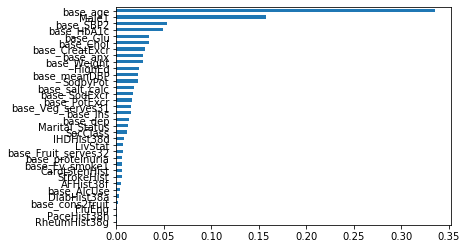

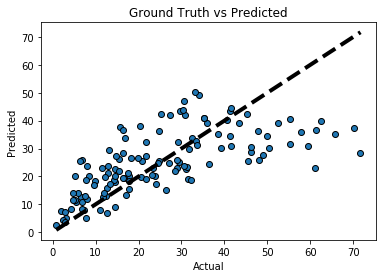

Mean squared error: 153.97
Test Variance score: 0.46
Test data R-2 score: 0.455
Test data Spearman correlation: 0.759
Test data Pearson correlation: 0.675


In [12]:
model_ranks=pd.Series(model.feature_importances_,index=x_training_set.columns,name="Importance").sort_values(ascending=True,inplace=False) 
ax=model_ranks.plot(kind='barh')

model_score = model.score(x_training_set,y_training_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('coefficient of determination R^2 of the prediction.: ',model_score)
y_predicted = model.predict(x_test_set)


#plot observed vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

#Model parameters study :
#The coefficient R^2 is defined as (1 – u/v), where u is the residual sum of squares ((y_true – y_pred) ** 2).sum() and v is the total sum of squares ((y_true – y_true.mean()) ** 2).sum(). 

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_predicted))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test_set, y_predicted))


test_score = r2_score(y_test_set, y_predicted)
spearman = spearmanr(y_test_set, y_predicted)
pearson = pearsonr(y_test_set, y_predicted)

#print(f'Out-of-bag R-2 score estimate: {model.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [13]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
#https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
#calculate shapley values
#https://github.com/slundberg/shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_training_set)



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_training_set.iloc[0,:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values, x_training_set)

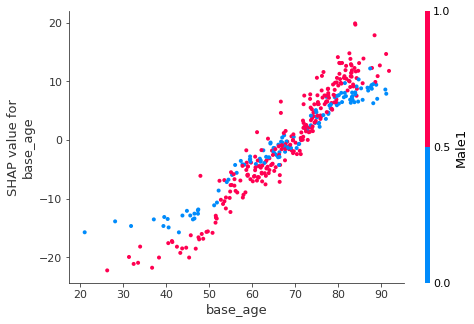

In [16]:
#partial dependency plot shows the marginal effect one or two features have on the predicted outcome 
#the plot show positive relationship with male sex
shap.dependence_plot("base_age", shap_values, x_training_set)

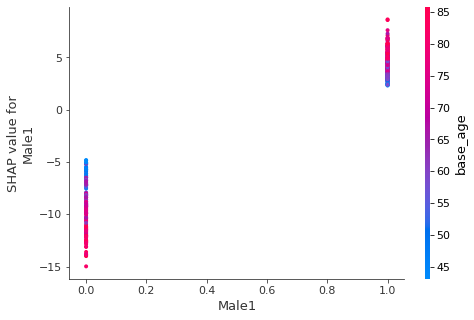

In [17]:
shap.dependence_plot("Male1", shap_values, x_training_set)

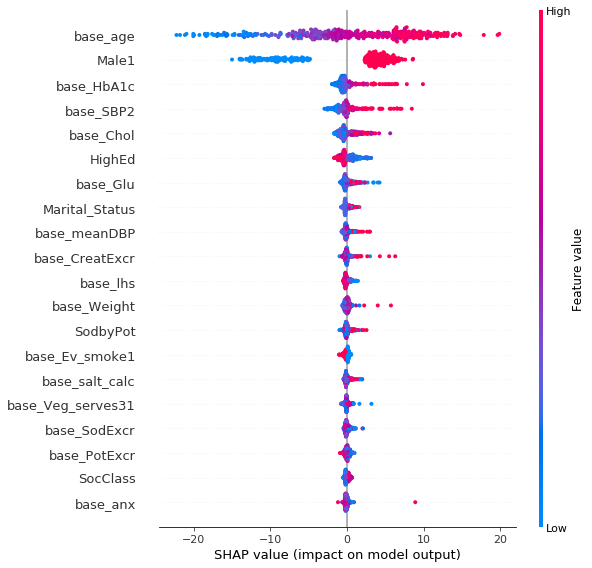

In [18]:
#positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, x_training_set)

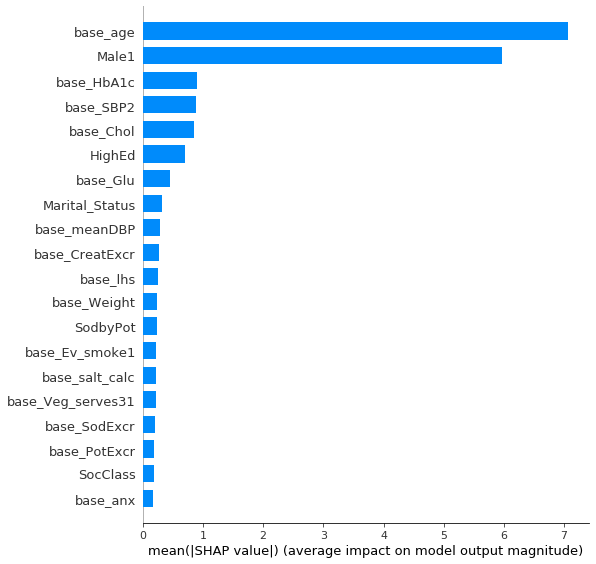

In [19]:
shap.summary_plot(shap_values, x_training_set, plot_type="bar")

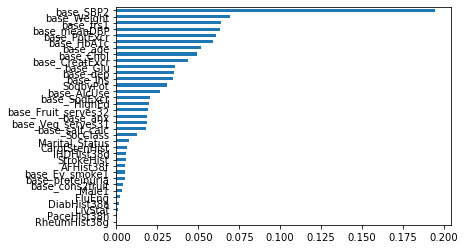

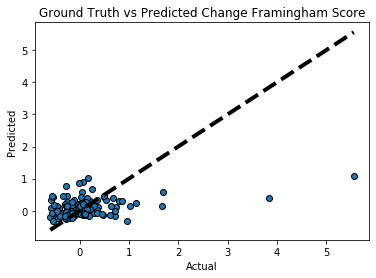

coefficient of determination R^2 of the prediction.:  0.8755137001268326
Mean squared error: 0.44
Test Variance score: 0.15
Test data R-2 score: 0.149
Test data Spearman correlation: 0.289
Test data Pearson correlation: 0.387


In [20]:
#second model change frs
n_estimators=200
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model2 = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model2.fit(x_training2_set, y_training2_set)

#predict test results
#y_pred=model2.predict(x_test2_set)
y_predicted = model2.predict(x_test2_set)

model2_ranks=pd.Series(model2.feature_importances_,index=x_training2_set.columns,name="Importance").sort_values(ascending=True,inplace=False) 
ax=model2_ranks.plot(kind='barh')

#plot observed vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test2_set, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test2_set.min(), y_test2_set.max()], [y_test2_set.min(), y_test2_set.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted Change Framingham Score")
plt.show()

model2_score = model2.score(x_training2_set,y_training2_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('coefficient of determination R^2 of the prediction.: ',model2_score)


# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test2_set, y_predicted))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test2_set, y_predicted))


test_score = r2_score(y_test2_set, y_predicted)
spearman = spearmanr(y_test2_set, y_predicted)
pearson = pearsonr(y_test2_set, y_predicted)

#print(f'Out-of-bag R-2 score estimate: {model.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


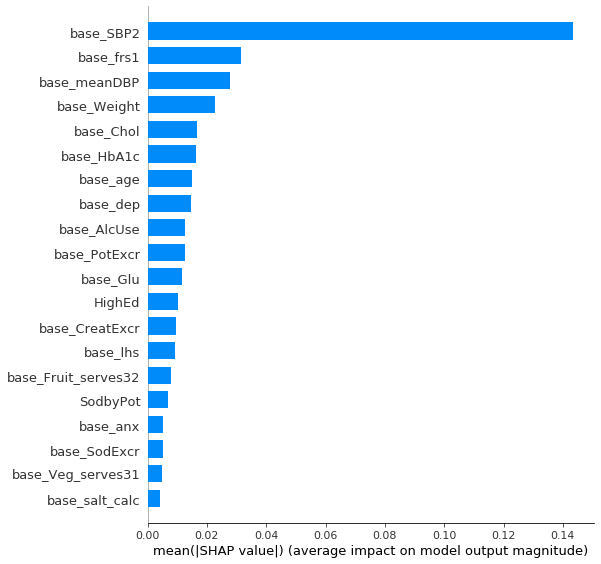

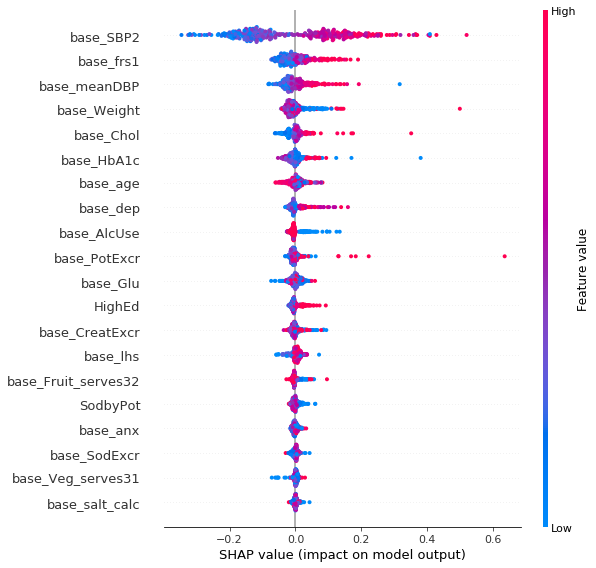

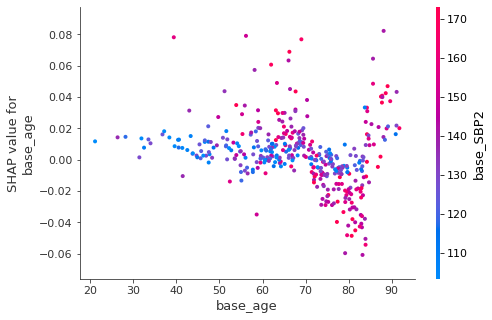

In [21]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
#calculate shapley values
shap_values = shap.TreeExplainer(model2).shap_values(x_training2_set)
shap.summary_plot(shap_values, x_training2_set, plot_type="bar")

#positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, x_training2_set)

#partial dependency plot shows the marginal effect one or two features have on the predicted outcome 
#the plot show positive relationship with SBP
shap.dependence_plot('base_age', shap_values, x_training2_set)

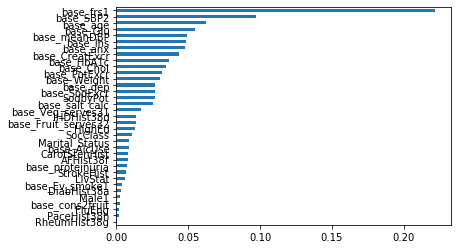

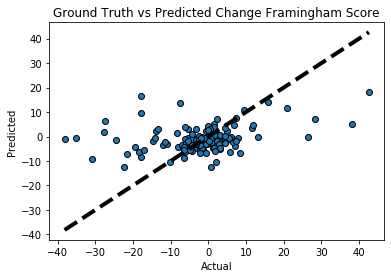

coefficient of determination R^2 of the prediction.:  0.8840549866466322
Mean squared error: 121.78
Test Variance score: 0.08
Test data R-2 score: 0.0845
Test data Spearman correlation: 0.278
Test data Pearson correlation: 0.326


In [22]:
#third model raw change frs
n_estimators=200
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model3 = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model3.fit(x_training3_set, y_training3_set)

#predict test results
#y_pred=model2.predict(x_test2_set)
y_predicted = model3.predict(x_test3_set)

model3_ranks=pd.Series(model3.feature_importances_,index=x_training3_set.columns,name="Importance").sort_values(ascending=True,inplace=False) 
ax=model3_ranks.plot(kind='barh')

#plot observed vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test3_set, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test3_set.min(), y_test3_set.max()], [y_test3_set.min(), y_test3_set.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted Change Framingham Score")
plt.show()

model3_score = model3.score(x_training3_set,y_training3_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('coefficient of determination R^2 of the prediction.: ',model3_score)


# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test3_set, y_predicted))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test3_set, y_predicted))


test_score = r2_score(y_test3_set, y_predicted)
spearman = spearmanr(y_test3_set, y_predicted)
pearson = pearsonr(y_test3_set, y_predicted)

#print(f'Out-of-bag R-2 score estimate: {model.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [23]:
#create pca object
pca = PCA()
X_train = pca.fit_transform(x_training_set)
X_test = pca.transform(x_test_set)
explained_variance = pca.explained_variance_ratio_


Text(0, 0.5, 'Second Principal Component')

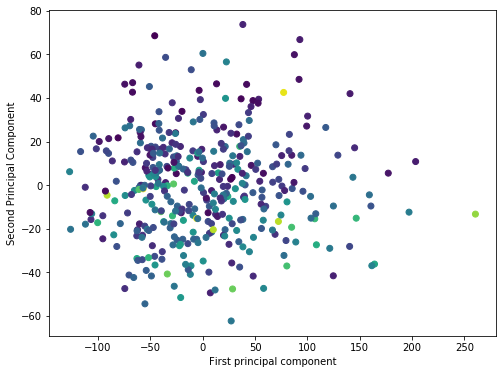

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_training_set)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [25]:
pca = PCA()
pca.fit(x_training_set)
cpts = pd.DataFrame(pca.transform(x_training_set))
x_axis = np.arange(1, pca.n_components_+1)

#pca_scaled = PCA()
#pca_scaled.fit(X_train_scaled)
#cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))


In [26]:
#initialise tsne
tsne = TSNE(n_components=2, perplexity=10,random_state=0)
#perform tsne
tsne_obj= tsne.fit_transform(x_training_set)
#create data frame from results
#first dimension label X
#second dimension label Y
#outcome variable label Outcome
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'changefrs':y_training2_set})
#merge data frames by columns
df = pd.concat([x_training_set,tsne_df],axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

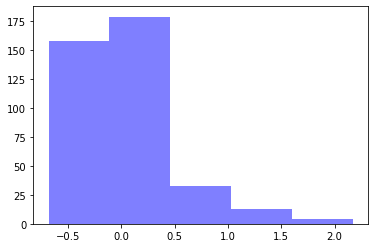

In [27]:
df
num_bins = 5
n, bins, patches = plt.hist(df['changefrs'], num_bins, facecolor='blue', alpha=0.5)
plt.show

In [28]:
#change column values
#https://datascience.stackexchange.com/questions/64855/pandas-apply-function-with-multiple-condition
#df = pd.DataFrame({"age": [-100, 300, 400, 500, 600, 700]})
#df["age"].loc[(df["age"] < 500) & (df["age"] >= 0)] = 0

df["changefrs"].loc[(df["changefrs"] >= 1) ] = 4
df["changefrs"].loc[(df["changefrs"] >= 0.5) & (df["changefrs"] <1) ] = 3
df["changefrs"].loc[(df["changefrs"] >= 0) & (df["changefrs"] <.5) ] = 2
df["changefrs"].loc[(df["changefrs"] <0) ] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


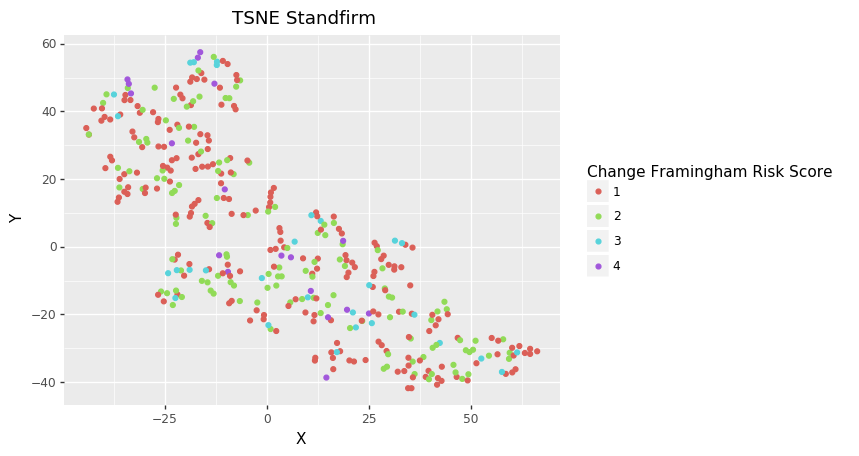

<ggplot: (123578774122)>

In [29]:
from plotnine import *
#ggplot style
#note the use of data merged from tsne output
(ggplot (df)
 + geom_point(aes('X ', 'Y',color='factor(changefrs)'))
)+labs(color="Change Framingham Risk Score")+ggtitle("TSNE Standfirm")